In [1]:
# Import necessary library:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Access the webcam and save a snapshot of disorted image.

In [3]:

# Reference: https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display

cap = cv2.VideoCapture(0)                           # 0 is the default camera index
if not cap.isOpened():
    print("Cannot open camera")
    exit()

# Variables for video recording
recording = False
out = None

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    cv2.imshow('BGR Frame', frame)

    # Get key press
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break

    elif key == ord('s'):
        # Create filename with timestamp
        filename = f"snapshot_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.jpg"
        cv2.imwrite(filename, frame)
        print(f"Snapshot saved as {filename}")

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

## Load the calibration we saved earlier using `calibrate_camera.py`

In [3]:
data = np.load('calibration.npz')
mtx = data['mtx']         # camera matrix
dist = data['dist']       # distortion coefficients
rvecs = list(data['rvecs'])
tvecs = list(data['tvecs'])

## Visualise the image

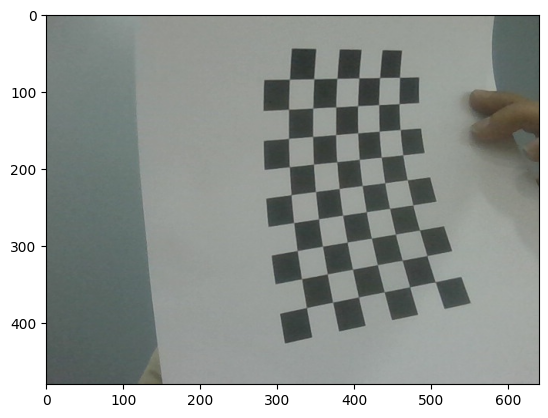

In [21]:
img = cv2.imread('snapshot_20250921_095514.jpg')
# Plot the distorted image in matplotlib
fig = plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Get some corners and plot a line through these points

In [5]:
import matplotlib
matplotlib.use('tkagg')  # ensures a clickable window

In [6]:
# Click event function
def onclick(event):
    ix, iy = event.xdata, event.ydata
    if ix is not None and iy is not None:  # ignore clicks outside the image
        print(f"Clicked at: ({int(ix)}, {int(iy)})")

# Display image
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Connect the click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show(block=True)

Clicked at: (284, 83)
Clicked at: (303, 387)


In [7]:
fig.canvas.mpl_disconnect(cid)
%matplotlib inline

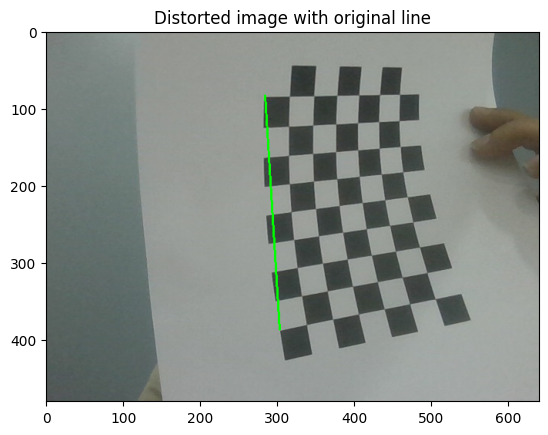

In [22]:
# Plot the lines on the distorted image
# Define points (these should be chosen based on the clicked points)

points = np.array([[284,83], [303,387]], dtype=np.float32)
# Draw the line on the distorted image
img_with_line = img.copy()
cv2.line(img_with_line, tuple(points[0].astype(int)), tuple(points[1].astype(int)), (0, 255, 0), 2)

# Plot the image with the line
fig = plt.figure()
plt.title('Distorted image with original line')
plt.imshow(cv2.cvtColor(img_with_line, cv2.COLOR_BGR2RGB))

## Undistort

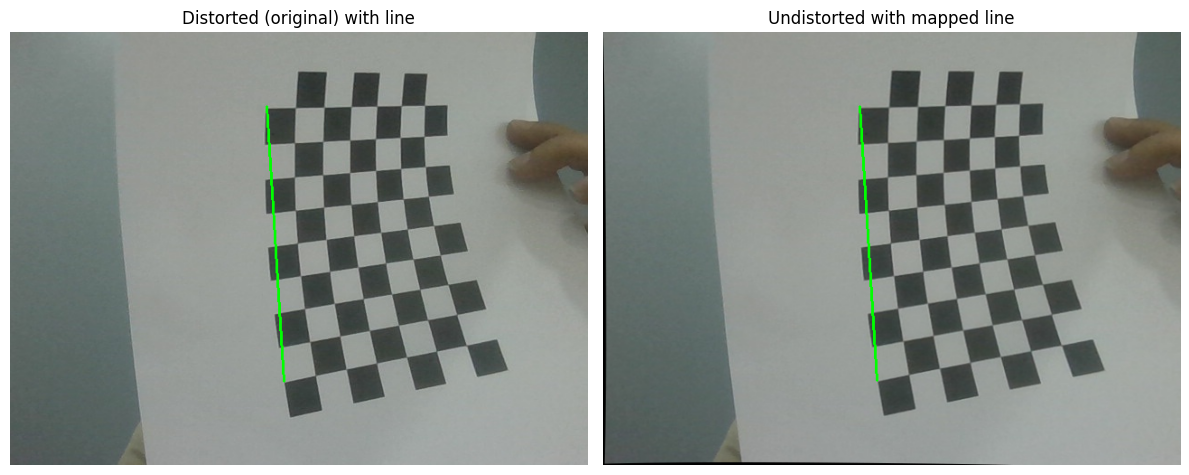

In [24]:
# Straightforward undistort
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('undistorted.png', undistorted)

# map the distorted points -> undistorted pixel coordinates
pts_cv = points.reshape(-1, 1, 2)                                   # shape (N,1,2)
undistorted_pts = cv2.undistortPoints(pts_cv, mtx, dist, P=mtx)     # returns (N,1,2)
undistorted_pts = undistorted_pts.reshape(-1, 2)                    # shape (N,2)

# Round/convert to int for drawing
pts_int = np.round(undistorted_pts).astype(int)
p0 = tuple(pts_int[0])
p1 = tuple(pts_int[1])

# Draw the line on the undistorted image
undistorted_with_line = undistorted.copy()
cv2.line(undistorted_with_line, p0, p1, (0, 255, 0), 2)

# Show both images side-by-side with matplotlib
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(cv2.cvtColor(img_with_line, cv2.COLOR_BGR2RGB))
axes[0].set_title('Distorted (original) with line'); axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(undistorted_with_line, cv2.COLOR_BGR2RGB))
axes[1].set_title('Undistorted with mapped line'); axes[1].axis('off')
plt.tight_layout()
plt.show()

In [25]:
# Get an optimal new camera matrix (removes black pixels / can crop) and undistort

h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

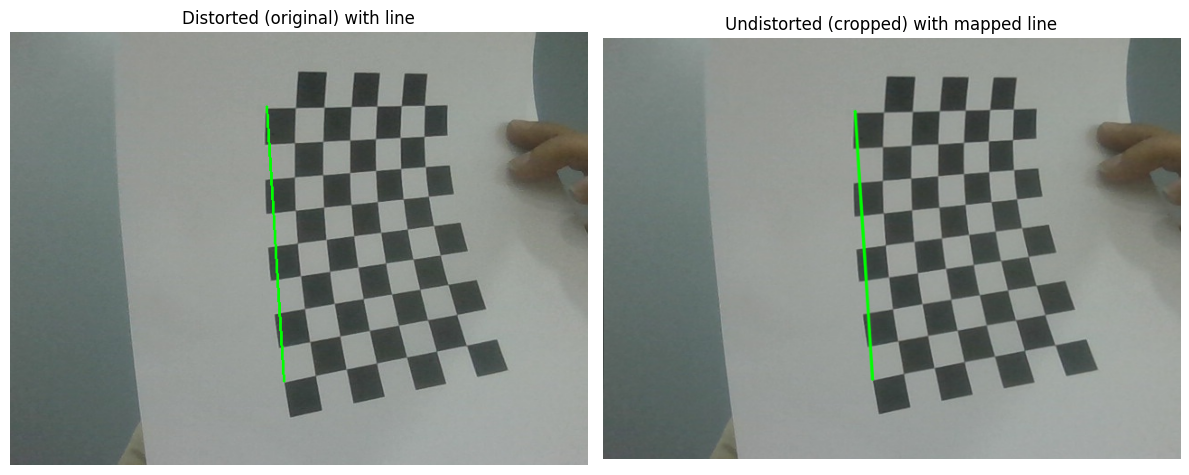

In [26]:
# undistort
dst_full = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop using roi (roi could be (0,0,0,0) if no cropping)
x_roi, y_roi, w_roi, h_roi = roi
if w_roi > 0 and h_roi > 0:
    dst = dst_full[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
else:
    # nothing to crop (alpha=1 often gives full frame), so keep full undistorted image
    dst = dst_full.copy()

# Save the undistorted image
cv2.imwrite('calibresult.png', dst)

# Map the original distorted points -> undistorted pixel coordinates (using P=newcameramtx)
pts_cv = points.reshape(-1, 1, 2)                                       # (N,1,2)
undist_pts = cv2.undistortPoints(pts_cv, mtx, dist, P=newcameramtx)     # returns (N,1,2)
undist_pts = undist_pts.reshape(-1, 2)                                  # (N,2)

# If you cropped the undistorted image, subtract the roi origin so the coords match the cropped image
if w_roi > 0 and h_roi > 0:
    undist_pts[:, 0] -= x_roi
    undist_pts[:, 1] -= y_roi

# Round/convert to ints for drawing
pts_int = np.round(undist_pts).astype(int)
p0_u = tuple(pts_int[0])
p1_u = tuple(pts_int[1])

# Draw mapped line on undistorted cropped image
img_undist_line = dst.copy()
cv2.line(img_undist_line, p0_u, p1_u, (0,255,0), 2, lineType=cv2.LINE_AA)


# Show both images side-by-side with matplotlib
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(cv2.cvtColor(img_with_line, cv2.COLOR_BGR2RGB))
axes[0].set_title('Distorted (original) with line'); axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(img_undist_line, cv2.COLOR_BGR2RGB))
axes[1].set_title('Undistorted (cropped) with mapped line'); axes[1].axis('off')
plt.tight_layout()
plt.show()